# Image Similarity & Retrieval System (fastai)

The overall goal of this project is train a set of models to determine when provided a new image (in this case a frame from one of the MCU movies), we seek to provide an output of the closest __similar images__ related to the queries image/scene. In other words, given an image and a library of images, retireve the closes K similar images to queried image. This objective is achieved by:
* leverage pre-trained models to extract features of images and index the nearest neighbor
* Retrieve similar images by calculating similarity distances between inquired image and images in the databse. 

### Imports

First we make sure any libraries that are edited during project development and experiments are reset reload automatically. Addiitonally we are utilizing the FastAI livrary that sits on top of Pytorch. Unlike other notebooks in this repo, we are using Pytorch instead of Tensorflow, however you can think of the fastAI library to Pytorch similar to Keras is to Tensorflow. 

In [1]:
%reload_ext autoreload
%autoreload 2

In [5]:
# fast.ai libraries
from fastai.vision import *
from fastai.callbacks.hooks import *

# data/image/graphing processing libraries
import numpy as np
import pandas as pd
import pickle
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


from tqdm import tqdm_notebook
pd.set_option('display.max_columns', 500)

## similarity libraries
#!pip install lshash3==0.0.8
from lshash.lshash import LSHash


### Data Processing and Augmentation

Fastai is great, we can utilize thier builtin `get_transforms()` to transform a bunch of images per our specificaions.

In [17]:
path = Path('./images/image_folders/')
path.ls()[:8]

[PosixPath('images/image_folders/thorragnarok'),
 PosixPath('images/image_folders/thor2darkworld'),
 PosixPath('images/image_folders/ironman2'),
 PosixPath('images/image_folders/avengers3'),
 PosixPath('images/image_folders/drstrange'),
 PosixPath('images/image_folders/guardians2'),
 PosixPath('images/image_folders/avengers2'),
 PosixPath('images/image_folders/spiderverse')]

In [19]:
# get_transforms??
tfms = get_transforms()

data = (ImageList.from_folder(path)
        .random_split_by_pct(0.2)
        .label_from_folder()
        .transform(tfms=tfms, size=224)
        .databunch(bs=64)
        .normalize(imagenet_))

print("------ Data Specifications ------")
print(data)

print("------ Data Set Specifications ------")
print("Number of train images:  ", len(data.train_ds.x))
print("Number of test images :  ",len(data.valid_ds.x))
print("Number of image folders: ",len(data.classes))
print(data.classes)

/home/redne/anaconda3/envs/pytorch/lib/python3.7/site-packages/fastai/data_block.py:212: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


------ Data Specifications ------
ImageDataBunch;

Train: LabelList (3605 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
thorragnarok,thorragnarok,thorragnarok,thorragnarok,thorragnarok
Path: images/image_folders;

Valid: LabelList (901 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
mcu_images,mcu_images,mcu_images,avengers3,mcu_images
Path: images/image_folders;

Test: None
------ Data Set Specifications ------
Number of train images:   3605
Number of test images :   901
Number of image folders:  21
['antman1', 'antman2', 'avengers1', 'avengers2', 'avengers3', 'avengers4', 'blackpanther', 'capamerica1', 'capamerica2', 'capamerica3', 'capmarvel', 'drstrange', 'guardians1', 'guardians2', 'ironman2', 'mcu_images', 'spidermanhomecoming', 'spiderverse', 'test', 'thor2darkworld', 'thorragnarok']


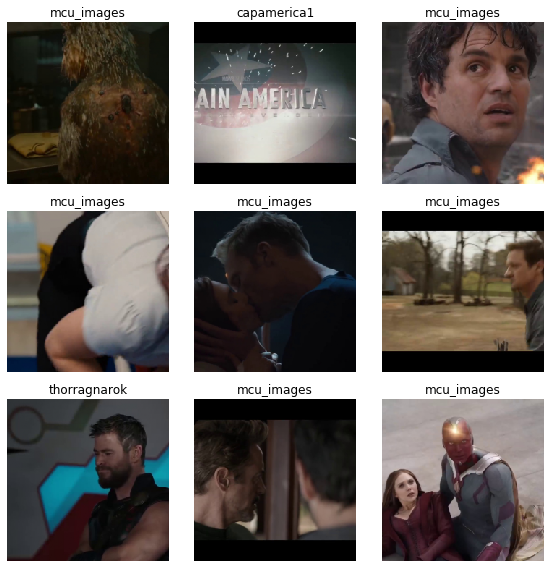

In [15]:
data.show_batch(rows=3, figsize=(8,8))

Below is an example of the various transformations the `get_transforms()` functions provides

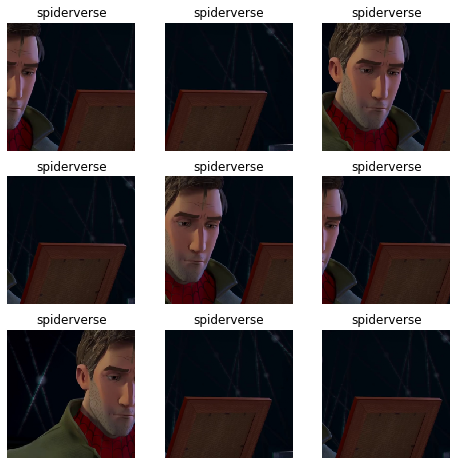

In [16]:
def _plot(i, j, ax):
    x, y = data.train_ds[432]
    x.show(ax, y=y)
plot_multi(_plot, 3, 3, figsize=(8, 8))

In [11]:
data.train_ds.to_df().head()

,x,y
0,thorragnarok/thorragnarok_37.jpg,thorragnarok
1,thorragnarok/thorragnarok_10.jpg,thorragnarok
2,thorragnarok/thorragnarok_67.jpg,thorragnarok
3,thorragnarok/thorragnarok_23.jpg,thorragnarok
4,thorragnarok/thorragnarok_7.jpg,thorragnarok


In [12]:
data.valid_ds.x.items

array([PosixPath('images/image_folders/mcu_images/mcu_recap_cramit_1155.jpg'),
       PosixPath('images/image_folders/mcu_images/mcu_recap_cramit_657.jpg'),
       PosixPath('images/image_folders/guardians1/guardians1_34.jpg'),
       PosixPath('images/image_folders/mcu_images/mcu_villian_looper_85.jpg'), ...,
       PosixPath('images/image_folders/mcu_images/mcu_recap_cramit_474.jpg'),
       PosixPath('images/image_folders/antman1/antman1_39.jpg'),
       PosixPath('images/image_folders/capamerica2/capamerica2_27.jpg'),
       PosixPath('images/image_folders/mcu_images/mcu_recap_cramit_913.jpg')], dtype=object)

thorragnarok


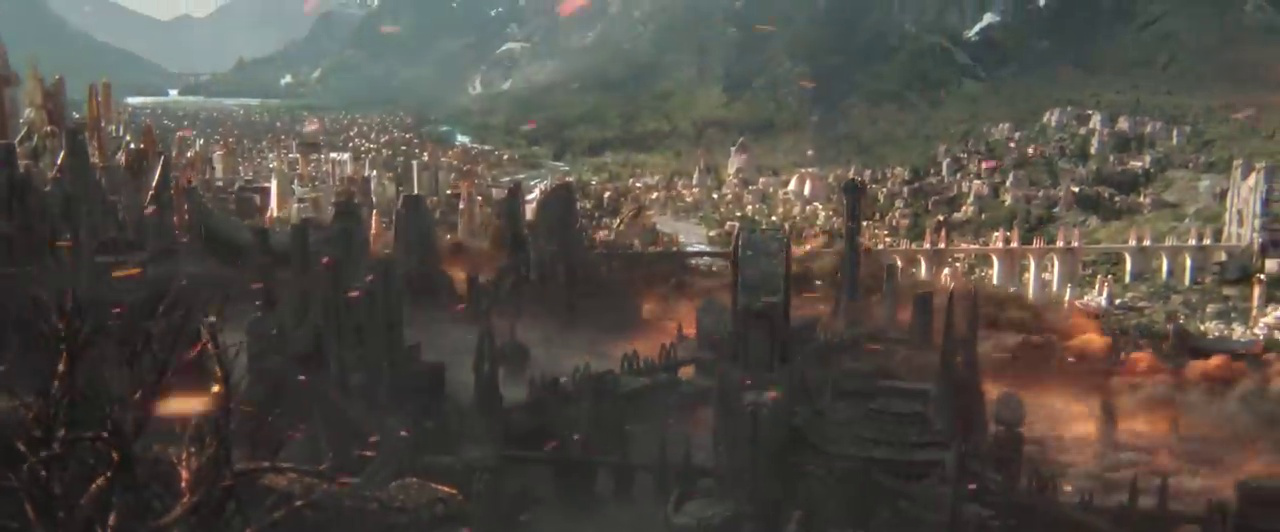

In [13]:
print(data.train_ds.y[0])
data.train_ds.x[0]

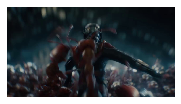

In [18]:
img= open_image(get_image_files(path/'antman1')[20])
img.show()

## Model Training - ResNet34

We are using a fully connected convolutional neural network with a single hidden layer as a classiffier. 

Whats a Convolutional Neural Network, here is a great crash course - http://cs231n.github.io/convolutional-networks/

additional architectural details:
* performance metric = accuracy
* dropout regularization = 0.5 (final layer); 0.25 (remaining layers)

In [22]:
# downoad pretrained model and create
learn = cnn_learner(data, models.resnet34, pretrained=True, metrics=accuracy)

# prints out model parameters
learn.model[1]
#learn.summary()

We utilize `lr_find()` function to run an experimental trial to determine an appropriate learning rate. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


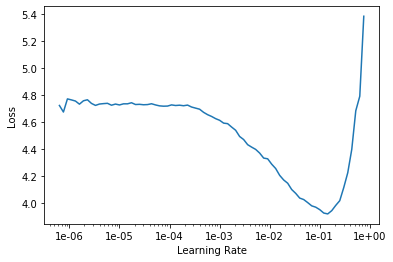

In [23]:
learn.lr_find()
learn.recorder.plot()

Time to start training. We will use fit 1 training cycle for 5 epochs. Depending on the amount of data... well, generally, its best to use a gpu for the next couple of cells. 

In [33]:
learn.fit_one_cycle(5, max_lr=slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.047615,1.785665,0.615982,00:45
1,2.025956,1.447354,0.678135,00:44
2,1.540609,1.169105,0.675916,00:44
3,1.163644,1.141109,0.711432,00:44
4,0.943475,1.112175,0.723640,00:44


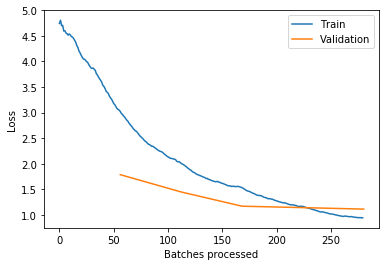

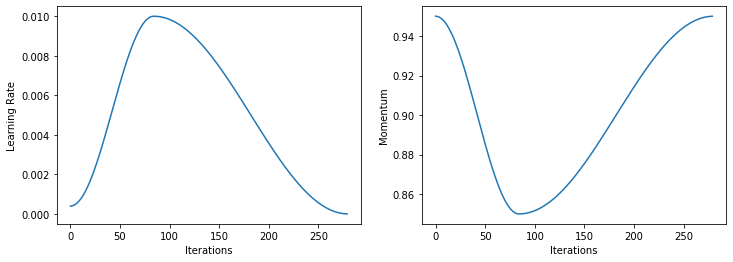

In [35]:
learn.recorder.plot_losses();
learn.recorder.plot_lr(show_moms=True)

__Save Model__

In [ ]:
learn.save('mcu_resnet34_101319')

__Load Model__

In [ ]:
#learn.load('mcu_resnet34_101319')              

## Creating Image Features



## Extracting Feature

Creating a hook right after convolutional part of resnet 50 and max pooling layer which generates a 4096 length vector for a particular image of 256*256.

In [49]:
# thanks Aayush https://towardsdatascience.com/finding-similar-images-using-deep-learning-and-locality-sensitive-hashing-9528afee02f5
# this is a hook (learned about it here: https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903/13)
# hooks are used for saving intermediate computations
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()
        
sf = SaveFeatures(learn.model[1][5]) ## Output before the last FC layer

Creating Feature Vector

In [72]:
SaveFeatures??

Init signature: SaveFeatures(m)
Docstring:      <no docstring>
Type:           type
Subclasses:     


In [50]:
## By running this feature vectors would be saved in sf variable initated above
_= learn.get_preds(data.train_ds)
_= learn.get_preds(DatasetType.Valid)

Create the featuer fectors

In [58]:
predictions = learn.get_preds()

Converting in a dictionary of {img_path:featurevector}

In [52]:
img_path = [str(x) for x in (list(data.train_ds.items)+list(data.valid_ds.items))]
feature_dict = dict(zip(img_path,sf.features))

In [68]:
img_path[:5]

['images/image_folders/thorragnarok/thorragnarok_10.jpg',
 'images/image_folders/thorragnarok/thorragnarok_67.jpg',
 'images/image_folders/thorragnarok/thorragnarok_23.jpg',
 'images/image_folders/thorragnarok/thorragnarok_30.jpg',
 'images/image_folders/thorragnarok/thorragnarok_65.jpg']

In [70]:
predictions

[tensor([[4.7087e-04, 1.6499e-04, 5.5957e-03,  ..., 2.1453e-04, 8.4305e-03,
          1.3133e-04],
         [3.2138e-04, 3.6866e-05, 1.1405e-04,  ..., 2.4455e-05, 5.4790e-03,
          2.3940e-05],
         [4.4270e-04, 7.1998e-05, 8.0784e-07,  ..., 2.4311e-05, 1.9716e-05,
          1.7603e-04],
         ...,
         [1.6007e-05, 1.2708e-03, 8.7547e-05,  ..., 8.4033e-06, 5.8267e-05,
          2.4793e-02],
         [2.8254e-04, 6.3557e-03, 3.6315e-03,  ..., 3.2141e-05, 1.9474e-04,
          8.6349e-02],
         [3.3086e-04, 1.2845e-05, 3.8530e-04,  ..., 6.8050e-06, 3.3304e-03,
          2.8622e-05]]),
 tensor([15, 15, 15,  4, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
         15, 15,  8, 19, 15, 15,  5,  5, 15, 17,  8, 15, 19, 15, 15, 15, 15, 15,
         15, 15, 14, 15,  6,  6, 15,  1,  2,  1, 15, 12, 15, 15, 15,  5,  0, 15,
         15, 20, 15, 15, 15, 15,  1,  0, 15, 15, 15, 15, 16, 15, 15, 13, 15, 15,
         12, 15,  7, 15, 15, 17, 13,  1,  7, 15, 15, 15, 12, 20, 1

In [69]:
sf.features

array([[ 0.      ,  0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ,  5.76809 ],
       [ 0.      ,  2.150033,  0.07703 ,  9.489058, ...,  0.      ,  2.012707,  0.      ,  8.254207],
       [ 0.      ,  3.177753,  0.      ,  2.231376, ...,  0.      ,  0.      ,  1.449957, 12.734337],
       [ 1.894898,  7.011625,  1.356666,  5.065745, ...,  0.      ,  4.092311,  1.92749 ,  9.471476],
       ...,
       [ 0.      ,  3.130539,  5.608463,  0.      , ...,  0.      ,  3.220184,  0.      ,  7.334783],
       [ 6.064991,  5.450221,  0.      ,  0.      , ...,  7.540674,  0.      ,  7.854773,  8.243437],
       [ 0.      ,  1.569832,  0.      ,  5.213923, ..., 10.027488,  0.      , 11.531847,  9.10162 ],
       [ 0.      ,  0.      ,  0.      ,  0.      , ...,  1.356484,  7.221955,  3.12609 ,  0.      ]], dtype=float32)

In [66]:
feature_dict

{'images/image_folders/thorragnarok/thorragnarok_10.jpg': array([0.     , 0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     , 5.76809], dtype=float32),
 'images/image_folders/thorragnarok/thorragnarok_67.jpg': array([0.      , 2.150033, 0.07703 , 9.489058, ..., 0.      , 2.012707, 0.      , 8.254207], dtype=float32),
 'images/image_folders/thorragnarok/thorragnarok_23.jpg': array([ 0.      ,  3.177753,  0.      ,  2.231376, ...,  0.      ,  0.      ,  1.449957, 12.734337], dtype=float32),
 'images/image_folders/thorragnarok/thorragnarok_30.jpg': array([1.894898, 7.011625, 1.356666, 5.065745, ..., 0.      , 4.092311, 1.92749 , 9.471476], dtype=float32),
 'images/image_folders/thorragnarok/thorragnarok_65.jpg': array([ 1.973884,  3.149651,  5.407764,  5.468905, ...,  0.      ,  4.290801,  0.165189, 12.041047], dtype=float32),
 'images/image_folders/thorragnarok/thorragnarok_69.jpg': array([ 0.      ,  3.871683,  0.      ,  8.444009, ...,  0.      ,  0.      ,  0.      , 16.399885]

Here is the path were we wills tore all of the model information from this experiment

In [54]:
model_dir = Path('./model_config/')

Save the feature dictionary 

In [22]:

pickle.dump(feature_dict, open(model_dir/"feature_dict.p", "wb"))

## Using Locality Sensitive hashing to find near similar images

In [4]:
## Loading Feature dictionary
feature_dict = pickle.load(open(path/'feature_dict.p','rb'))

In [54]:
from pandas.io.json import json_normalize
k = json_normalize(feature_dict)
print("image file path: ", list(feature_dict.keys())[0])
print("number of features from images: ", len(feature_dict[list(feature_dict.keys())[0]]))

image file path:  images/image_folders/thorragnarok/thorragnarok_37.jpg
number of features from images:  512


In [153]:
from pandas.io.json import json_normalize
k = json_normalize(feature_dict)
k.head()

,images/image_folders/thorragnarok/thorragnarok_37.jpg,images/image_folders/thorragnarok/thorragnarok_10.jpg,images/image_folders/thorragnarok/thorragnarok_67.jpg,images/image_folders/thorragnarok/thorragnarok_23.jpg,images/image_folders/thorragnarok/thorragnarok_30.jpg,images/image_folders/thorragnarok/thorragnarok_65.jpg,images/image_folders/thorragnarok/thorragnarok_69.jpg,images/image_folders/thorragnarok/thorragnarok_7.jpg,images/image_folders/thorragnarok/thorragnarok_61.jpg,images/image_folders/thorragnarok/thorragnarok_19.jpg,images/image_folders/thorragnarok/thorragnarok_5.jpg,images/image_folders/thorragnarok/thorragnarok_8.jpg,images/image_folders/thorragnarok/thorragnarok_39.jpg,images/image_folders/thorragnarok/thorragnarok_12.jpg,images/image_folders/thorragnarok/thorragnarok_35.jpg,images/image_folders/thorragnarok/thorragnarok_55.jpg,images/image_folders/thorragnarok/thorragnarok_71.jpg,images/image_folders/thorragnarok/thorragnarok_51.jpg,images/image_folders/thorragnarok/thorragnarok_33.jpg,images/image_folders/thorragnarok/thorragnarok_53.jpg,images/image_folders/thorragnarok/thorragnarok_20.jpg,images/image_folders/thorragnarok/thorragnarok_32.jpg,images/image_folders/thorragnarok/thorragnarok_21.jpg,images/image_folders/thorragnarok/thorragnarok_58.jpg,images/image_folders/thorragnarok/thorragnarok_3.jpg,images/image_folders/thorragnarok/thorragnarok_17.jpg,images/image_folders/thorragnarok/thorragnarok_40.jpg,images/image_folders/thorragnarok/thorragnarok_36.jpg,images/image_folders/thorragnarok/thorragnarok_57.jpg,images/image_folders/thorragnarok/thorragnarok_49.jpg,images/image_folders/thorragnarok/thorragnarok_70.jpg,images/image_folders/thorragnarok/thorragnarok_54.jpg,images/image_folders/thorragnarok/thorragnarok_43.jpg,images/image_folders/thorragnarok/thorragnarok_52.jpg,images/image_folders/thorragnarok/thorragnarok_28.jpg,images/image_folders/thorragnarok/thorragnarok_11.jpg,images/image_folders/thorragnarok/thorragnarok_1.jpg,images/image_folders/thorragnarok/thorragnarok_64.jpg,images/image_folders/thorragnarok/thorragnarok_14.jpg,images/image_folders/thorragnarok/thorragnarok_34.jpg,images/image_folders/thorragnarok/thorragnarok_13.jpg,images/image_folders/thorragnarok/thorragnarok_62.jpg,images/image_folders/thorragnarok/thorragnarok_6.jpg,images/image_folders/thorragnarok/thorragnarok_29.jpg,images/image_folders/thorragnarok/thorragnarok_60.jpg,images/image_folders/thorragnarok/thorragnarok_38.jpg,images/image_folders/thorragnarok/thorragnarok_41.jpg,images/image_folders/thorragnarok/thorragnarok_45.jpg,images/image_folders/thorragnarok/thorragnarok_47.jpg,images/image_folders/thorragnarok/thorragnarok_9.jpg,images/image_folders/thorragnarok/thorragnarok_2.jpg,images/image_folders/thorragnarok/thorragnarok_50.jpg,images/image_folders/thorragnarok/thorragnarok_68.jpg,images/image_folders/thorragnarok/thorragnarok_15.jpg,images/image_folders/thorragnarok/thorragnarok_48.jpg,images/image_folders/thorragnarok/thorragnarok_25.jpg,images/image_folders/thorragnarok/thorragnarok_44.jpg,images/image_folders/thorragnarok/thorragnarok_72.jpg,images/image_folders/thorragnarok/thorragnarok_73.jpg,images/image_folders/thorragnarok/thorragnarok_26.jpg,images/image_folders/thor2darkworld/thor2darkworld_74.jpg,images/image_folders/thor2darkworld/thor2darkworld_22.jpg,images/image_folders/thor2darkworld/thor2darkworld_44.jpg,images/image_folders/thor2darkworld/thor2darkworld_24.jpg,images/image_folders/thor2darkworld/thor2darkworld_30.jpg,images/image_folders/thor2darkworld/thor2darkworld_51.jpg,images/image_folders/thor2darkworld/thor2darkworld_73.jpg,images/image_folders/thor2darkworld/thor2darkworld_54.jpg,images/image_folders/thor2darkworld/thor2darkworld_1.jpg,images/image_folders/thor2darkworld/thor2darkworld_43.jpg,images/image_folders/thor2darkworld/thor2darkworld_25.jpg,images/image_folders/thor2darkworld/thor2darkworld_65.jpg,images/image_folders/thor2darkworld/thor2darkworld_9.jpg,images/image_fo

In [27]:
## Locality Sensitive Hashing
# params
k = 10 # hash size
L = 5  # number of tables
d = 512 # Dimension of Feature vector
lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

# LSH on all the images
for img_path, vec in tqdm_notebook(feature_dict.items()):
    lsh.index(vec.flatten(), extra_data=img_path)

In [29]:
## Exporting as pickle
pickle.dump(lsh, open(path/'lsh.p', "wb"))

## Visualizing Output

In [11]:
## Loading Feature dictionary
feature_dict = pickle.load(open(path/'feature_dict.p','rb'))
lsh = pickle.load(open(path/'lsh.p','rb'))

def get_similar_item(idx, feature_dict, lsh_variable, n_items=5):
    response = lsh_variable.query(feature_dict[list(feature_dict.keys())[idx]].flatten(), 
                     num_results=n_items+1, distance_func='euclidean')
    
    columns = 3
    rows = int(np.ceil(n_items+1/columns))
    fig=plt.figure(figsize=(2*rows, 3*rows))
    for i in range(1, columns*rows +1):
        if i<n_items+2:
            img = Image.open(response[i-1][0][1])
            fig.add_subplot(rows, columns, i).set_title("File name:  %s \nDistance Score: %d" % (os.path.basename(response[i-1][0][1]), response[i-1][1]))
            plt.imshow(img)
    
    plt.show()
    return response

In [62]:
print("number of rows: ", int(np.ceil(5+1/3)))
for i in range(1, 3*6+1): 
    if i<5+2: print(i)

number of rows:  6
1
2
3
4
5
6


In [71]:
print("Cosine distance score:      ", lsh.cosine_dist(feature_dict[list(feature_dict.keys())[0]],
                                                      feature_dict[list(feature_dict.keys())[1]]))

print("euclidean distance score:   ", lsh.euclidean_dist(feature_dict[list(feature_dict.keys())[0]],
                                                         feature_dict[list(feature_dict.keys())[1]]))

print("l1 norm distance score:     ", lsh.l1norm_dist(feature_dict[list(feature_dict.keys())[0]],
                                                    feature_dict[list(feature_dict.keys())[1]]))


print("LSH Query Doc")
print(lsh.query.__doc__)

Cosine distance score:       0.6639538453673007
euclidean distance score:    54.376465
l1 norm distance score:      745.7770916745067
LSH Query Doc
 Takes `query_point` which is either a tuple or a list of numbers,
        returns `num_results` of results as a list of tuples that are ranked
        based on the supplied metric function `distance_func`.

        :param query_point:
            A list, or tuple, or numpy ndarray that only contains numbers.
            The dimension needs to be 1 * `input_dim`.
            Used by :meth:`._hash`.
        :param num_results:
            (optional) Integer, specifies the max amount of results to be
            returned. If not specified all candidates will be returned as a
            list in ranked order.
        :param distance_func:
            (optional) The distance function to be used. Currently it needs to
            be one of ("hamming", "euclidean", "true_euclidean",
            "centred_euclidean", "cosine", "l1norm"). By default

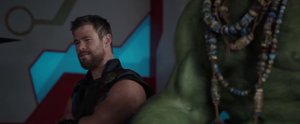

In [145]:
#Image.open(list(feature_dict.items())[20][0])
#display(Image.open(list(feature_dict.items())[20][0]))

size = 300, 300
im = Image.open(list(feature_dict.items())[6][0])
im.thumbnail(size)
im

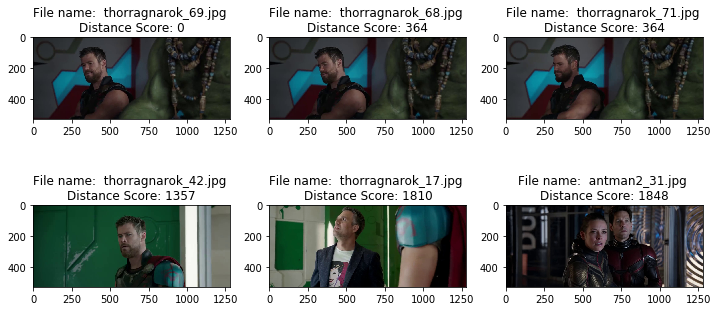

In [203]:
res = get_similar_item(6, feature_dict, lsh,5)

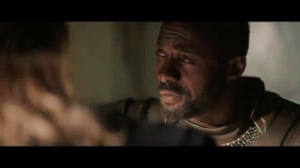

In [150]:
size = 300, 300
im = Image.open(list(feature_dict.items())[94][0])
im.thumbnail(size)
im

In [154]:
list(feature_dict.items())[94][0]

'images/image_folders/thor2darkworld/thor2darkworld_36.jpg'

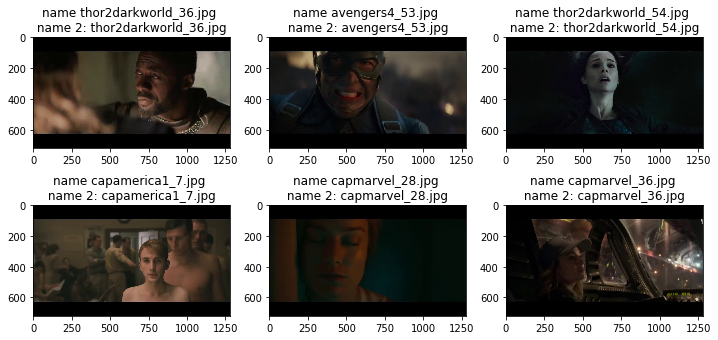

In [174]:
res = get_similar_item(94, feature_dict, lsh,5)

In [160]:
print("Image Name:           ", res[0][0][1])

Image Name:            images/image_folders/thor2darkworld/thor2darkworld_36.jpg


TypeError: 'method' object is not subscriptable

---
## Experiment

In [72]:
def calculate_scores_dist(images, dist='euclidean'):
    distances = pairwise_distances(images.reshape(len(images), -1), metric= dist)[0]
    for i,d in enumerate(distances):
        print('{} for image {:.4f}; {:.4f}'.format(dist, i, d))